<h1 align="center">Check Questions </h1> 

Ниже приводится список вопросов, с ответами на которые может быть полезно разобраться для понимания темы.

**Вопрос 1**: Чем отличаются современные сверточные сети от сетей 5 летней давности?

**Ответ:** В старых сверточных сетях были только Convolutional и Pooling Layers, да и вообще тема была непопулярной.  Сейчас же есть Dense, Activation Layers и др. (на сайте TF я видел еще названия, но не знаю, что они значат)

**Вопрос 2**: Какие неприятности могут возникнуть во время обучения современных нейросетей?

**Ответ:** Переобучение (для этого придумали Dropout), затухающие градиенты (см. Nesterov, adam и др.), все очень долго, и иногда кончается память.

**Вопрос 3**: У вас есть очень маленький датасет из 100 картинок, классификация, но вы очень хотите использовать нейросеть, какие неприятности вас ждут и как их решить? что делать если первый вариант  решения не заработает?

**Ответ:** 100 картинок - это очень мало. Что можно предложить - делать аугментацию данных. Еще я слышал про GAN, но не уверен, что может помочь здесь.

**Вопрос 4**: Можно ли сделать стайл трансфер для музыки и как?

**Ответ:** Мы можем закодировать аудио (см. преобразования Фурье). Дальше можем работать с аудио как с картинками. Применим CNN, а потом из массивов чисел сделаем обратно аудио.

---

<h1 align="center">CIFAR Quest</h1> 

In [1]:
# Load data
!mkdir cifar10
!curl -o cifar-10-python.tar.gz https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xvzf cifar-10-python.tar.gz -C cifar10

mkdir: cannot create directory ‘cifar10’: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  162M  100  162M    0     0  3264k      0  0:00:51  0:00:51 --:--:-- 3466k
cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [0]:
import _pickle as pickle
import os
import time
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

In [2]:
tf.__version__

'1.7.0'

In [3]:
tf.test.is_gpu_available()

True

In [0]:
def load_CIFAR_batch(filename):
    '''
        load single batch of cifar
    '''
    
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding='iso-8859-1')
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).astype("float")
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(ROOT):
    '''
        load all of cifar
    '''
    
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)    
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

In [0]:
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

cifar10_dir = './cifar10/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

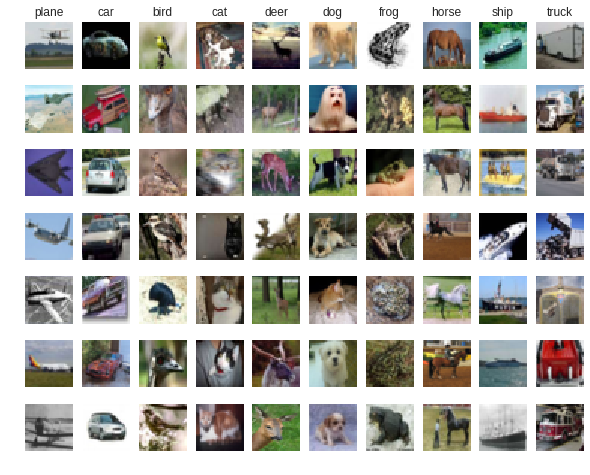

In [6]:
classes = ['plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8').transpose(1, 2, 0))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42)

In [1]:
def train_fn(X, y, sess):
    '''
        Train phase
        In: X[batch_size, channels, image_width, image_height]
            y[batch_size,]
        Out: (loss, accuracy)
    '''
    X = X.transpose(0, 2, 3, 1)
    y = y.reshape((batch_size, 1))
    sess.run(optimizer_step, {input_X : X, input_y : y})
    log_loss = sess.run(loss, {input_X : X, input_y : y})
    accuracy = sess.run(acc, {input_X : X, input_y : y})
    return (log_loss, accuracy[0])
    
def eval_fn(X, y, sess):
    '''
        Train phase
        In: X[batch_size, channels, image_width, image_height]
            y[batch_size,]
        Out: (loss, accuracy)
    '''
    X = X.transpose(0, 2, 3, 1)
    y = y.reshape((batch_size, 1))
    log_loss = sess.run(loss, {input_X : X, input_y : y})
    accuracy = sess.run(acc, {input_X : X, input_y : y})
    return (log_loss, accuracy[0])

In [0]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

ПЕРВАЯ НЕЙРОСЕТЬ

In [0]:
input_X = tf.placeholder('float32', shape=(None, 32, 32, 3))
input_y = tf.placeholder('int32', shape=(None, 1))

In [0]:
conv1 = tf.layers.conv2d(
    inputs=input_X,
    filters=64,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)

pool1 = tf.layers.max_pooling2d(
    inputs=conv1, 
    pool_size=[2, 2], 
    strides=2)

conv2 = tf.layers.conv2d(
    inputs=pool1,
    filters=128,
    kernel_size=[4, 4],
    padding="same",
    activation=tf.nn.elu)

pool2 = tf.layers.max_pooling2d(
    inputs=conv2, 
    pool_size=[2, 2], 
    strides=2)

dropout = tf.layers.dropout(
    inputs=pool2, 
    rate=0.2)

conv3 = tf.layers.conv2d(
    inputs=dropout,
    filters=256,
    kernel_size=[5, 5],
    padding="same",
    activation=tf.nn.tanh)

pool3 = tf.layers.max_pooling2d(
    inputs=conv3, 
    pool_size=[2, 2], 
    strides=2)

conv4 = tf.layers.conv2d(
    inputs=pool3,
    filters=512,
    kernel_size=[4, 4],
    padding="same",
    activation=tf.nn.relu)

pool4 = tf.layers.max_pooling2d(
    inputs=conv4, 
    pool_size=[2, 2], 
    strides=2)

pool4_flat = tf.reshape(pool4, [-1, 2 * 2 * 512])

dense = tf.layers.dense(
    inputs=pool4_flat, 
    units=1024, 
    activation=tf.nn.relu)

dropout = tf.layers.dropout(
    inputs=dense, 
    rate=0.2)

logits = tf.layers.dense(inputs=dropout, units=10)

loss = tf.losses.sparse_softmax_cross_entropy(labels=input_y, logits=logits)

optimizer_step = (
    tf.train.GradientDescentOptimizer(0.005, use_locking=True).minimize(loss))

y_pred = tf.argmax(input=logits, axis=1)
acc = tf.metrics.accuracy(labels=input_y, predictions=tf.argmax(input=logits, axis=1))

In [16]:
num_epochs = 20 
batch_size = 128

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    tf.local_variables_initializer().run()
    
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_loss = 0
        train_acc = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches(X_train, y_train, batch_size):
            inputs, targets = batch
            train_loss_batch, train_acc_batch = train_fn(inputs, targets, sess)
            train_loss += train_loss_batch
            train_acc += train_acc_batch
            train_batches += 1
    
        # And a full pass over the validation data:
        valid_loss = 0
        valid_acc = 0
        valid_batches = 0
        for batch in iterate_minibatches(X_val, y_val, batch_size):
            inputs, targets = batch
            valid_loss_batch, valid_acc_batch = eval_fn(inputs, targets, sess)
            valid_loss += valid_loss_batch
            valid_acc += valid_acc_batch
            valid_batches += 1
    
        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
        print("  train loss:\t\t{:.6f}".format(train_loss / train_batches))
        print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
        print("  valid loss:\t\t{:.6f}".format(valid_loss / valid_batches))
        print("  valid accuracy:\t\t{:.2f} %".format(valid_acc / valid_batches * 100))
    
    test_acc = 0
    test_batches = 0
    for batch in iterate_minibatches(X_test, y_test, 128):
        inputs, targets = batch
        _, tmp_acc = eval_fn(inputs, targets, sess)
        test_acc += tmp_acc
        test_batches += 1
    print("Final results:")
    print("  test accuracy:\t\t{:.2f} %".format(test_acc / test_batches * 100))

Epoch 1 of 20 took 35.858s
  train loss:		1.900063
  train accuracy:		26.32 %
  valid loss:		1.689703
  valid accuracy:		33.65 %
Epoch 2 of 20 took 35.415s
  train loss:		1.468763
  train accuracy:		37.77 %
  valid loss:		1.451059
  valid accuracy:		41.29 %
Epoch 3 of 20 took 35.443s
  train loss:		1.252710
  train accuracy:		43.87 %
  valid loss:		1.415448
  valid accuracy:		46.07 %
Epoch 4 of 20 took 35.340s
  train loss:		1.103310
  train accuracy:		47.93 %
  valid loss:		1.247261
  valid accuracy:		49.72 %
Epoch 5 of 20 took 35.338s
  train loss:		0.983854
  train accuracy:		51.30 %
  valid loss:		1.186352
  valid accuracy:		52.80 %
Epoch 6 of 20 took 35.373s
  train loss:		0.882952
  train accuracy:		54.12 %
  valid loss:		1.204219
  valid accuracy:		55.34 %
Epoch 7 of 20 took 35.388s
  train loss:		0.785516
  train accuracy:		56.50 %
  valid loss:		1.143391
  valid accuracy:		57.62 %
Epoch 8 of 20 took 35.366s
  train loss:		0.712840
  train accuracy:		58.63 %
  valid loss:		1.11

ВТОРАЯ НЕЙРОСЕТЬ

In [17]:
num_epochs = 50 
batch_size = 128

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    tf.local_variables_initializer().run()
    
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_loss = 0
        train_acc = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches(X_train, y_train, batch_size):
            inputs, targets = batch
            train_loss_batch, train_acc_batch = train_fn(inputs, targets, sess)
            train_loss += train_loss_batch
            train_acc += train_acc_batch
            train_batches += 1
    
        # And a full pass over the validation data:
        valid_loss = 0
        valid_acc = 0
        valid_batches = 0
        for batch in iterate_minibatches(X_val, y_val, batch_size):
            inputs, targets = batch
            valid_loss_batch, valid_acc_batch = eval_fn(inputs, targets, sess)
            valid_loss += valid_loss_batch
            valid_acc += valid_acc_batch
            valid_batches += 1
    
        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
        print("  train loss:\t\t{:.6f}".format(train_loss / train_batches))
        print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
        print("  valid loss:\t\t{:.6f}".format(valid_loss / valid_batches))
        print("  valid accuracy:\t\t{:.2f} %".format(valid_acc / valid_batches * 100))
    
    test_acc = 0
    test_batches = 0
    for batch in iterate_minibatches(X_test, y_test, 128):
        inputs, targets = batch
        _, tmp_acc = eval_fn(inputs, targets, sess)
        test_acc += tmp_acc
        test_batches += 1
    print("Final results:")
    print("  test accuracy:\t\t{:.2f} %".format(test_acc / test_batches * 100))

Epoch 1 of 50 took 35.409s
  train loss:		1.877250
  train accuracy:		27.15 %
  valid loss:		1.683524
  valid accuracy:		34.65 %
Epoch 2 of 50 took 35.339s
  train loss:		1.461982
  train accuracy:		38.47 %
  valid loss:		1.455519
  valid accuracy:		41.80 %
Epoch 3 of 50 took 35.400s
  train loss:		1.247936
  train accuracy:		44.30 %
  valid loss:		1.381318
  valid accuracy:		46.45 %
Epoch 4 of 50 took 35.345s
  train loss:		1.104748
  train accuracy:		48.31 %
  valid loss:		1.329491
  valid accuracy:		49.98 %
Epoch 5 of 50 took 35.423s
  train loss:		0.982710
  train accuracy:		51.46 %
  valid loss:		1.239166
  valid accuracy:		52.88 %
Epoch 6 of 50 took 35.439s
  train loss:		0.879843
  train accuracy:		54.19 %
  valid loss:		1.112527
  valid accuracy:		55.47 %
Epoch 7 of 50 took 35.360s
  train loss:		0.785837
  train accuracy:		56.66 %
  valid loss:		1.061838
  valid accuracy:		57.81 %
Epoch 8 of 50 took 35.351s
  train loss:		0.705101
  train accuracy:		58.89 %
  valid loss:		1.04

ТРЕТЬЯ НЕЙРОСЕТЬ

In [0]:
conv1 = tf.layers.conv2d(
    inputs=input_X,
    filters=64,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)

pool1 = tf.layers.max_pooling2d(
    inputs=conv1, 
    pool_size=[2, 2], 
    strides=2)

conv2 = tf.layers.conv2d(
    inputs=pool1,
    filters=128,
    kernel_size=[4, 4],
    padding="same",
    activation=tf.nn.elu)

pool2 = tf.layers.max_pooling2d(
    inputs=conv2, 
    pool_size=[2, 2], 
    strides=2)

dropout = tf.layers.dropout(
    inputs=pool2, 
    rate=0.25)

conv3 = tf.layers.conv2d(
    inputs=dropout,
    filters=256,
    kernel_size=[5, 5],
    padding="same",
    activation=tf.nn.tanh)

pool3 = tf.layers.max_pooling2d(
    inputs=conv3, 
    pool_size=[2, 2], 
    strides=2)

conv4 = tf.layers.conv2d(
    inputs=pool3,
    filters=512,
    kernel_size=[4, 4],
    padding="same",
    activation=tf.nn.relu)

pool4 = tf.layers.max_pooling2d(
    inputs=conv4, 
    pool_size=[2, 2], 
    strides=2)

pool4_flat = tf.reshape(pool4, [-1, 2 * 2 * 512])

dense = tf.layers.dense(
    inputs=pool4_flat, 
    units=1024, 
    activation=tf.nn.relu)

dropout = tf.layers.dropout(
    inputs=dense, 
    rate=0.25)

logits = tf.layers.dense(inputs=dropout, units=10)

loss = tf.losses.sparse_softmax_cross_entropy(labels=input_y, logits=logits)

optimizer_step = (
    tf.train.GradientDescentOptimizer(0.004, use_locking=True).minimize(loss))

y_pred = tf.argmax(input=logits, axis=1)
acc = tf.metrics.accuracy(labels=input_y, predictions=tf.argmax(input=logits, axis=1))

In [28]:
num_epochs = 50 
batch_size = 128
train_loss_plot = []
train_acc_plot = []
valid_loss_plot = []
valid_acc_plot = []

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    tf.local_variables_initializer().run()
    
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_loss = 0
        train_acc = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches(X_train, y_train, batch_size):
            inputs, targets = batch
            train_loss_batch, train_acc_batch = train_fn(inputs, targets, sess)
            train_loss += train_loss_batch
            train_acc += train_acc_batch
            train_batches += 1
    
        # And a full pass over the validation data:
        valid_loss = 0
        valid_acc = 0
        valid_batches = 0
        for batch in iterate_minibatches(X_val, y_val, batch_size):
            inputs, targets = batch
            valid_loss_batch, valid_acc_batch = eval_fn(inputs, targets, sess)
            valid_loss += valid_loss_batch
            valid_acc += valid_acc_batch
            valid_batches += 1
    
        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
        print("  train loss:\t\t{:.6f}".format(train_loss / train_batches))
        print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
        print("  valid loss:\t\t{:.6f}".format(valid_loss / valid_batches))
        print("  valid accuracy:\t\t{:.2f} %".format(valid_acc / valid_batches * 100))
        
        train_loss_plot += [train_loss]
        train_acc_plot += [train_acc]
        valid_loss_plot += [valid_loss]
        valid_acc_plot += [valid_acc]
    
    test_acc = 0
    test_batches = 0
    for batch in iterate_minibatches(X_test, y_test, 128):
        inputs, targets = batch
        _, tmp_acc = eval_fn(inputs, targets, sess)
        test_acc += tmp_acc
        test_batches += 1
    print("Final results:")
    print("  test accuracy:\t\t{:.2f} %".format(test_acc / test_batches * 100))

Epoch 1 of 50 took 35.503s
  train loss:		1.851222
  train accuracy:		29.19 %
  valid loss:		1.660640
  valid accuracy:		35.90 %
Epoch 2 of 50 took 35.342s
  train loss:		1.460041
  train accuracy:		39.61 %
  valid loss:		1.464746
  valid accuracy:		42.55 %
Epoch 3 of 50 took 35.418s
  train loss:		1.270511
  train accuracy:		44.77 %
  valid loss:		1.458272
  valid accuracy:		46.63 %
Epoch 4 of 50 took 35.386s
  train loss:		1.136063
  train accuracy:		48.25 %
  valid loss:		1.343033
  valid accuracy:		49.76 %
Epoch 5 of 50 took 35.394s
  train loss:		1.024008
  train accuracy:		51.13 %
  valid loss:		1.246572
  valid accuracy:		52.45 %
Epoch 6 of 50 took 35.382s
  train loss:		0.927497
  train accuracy:		53.66 %
  valid loss:		1.177750
  valid accuracy:		54.80 %
Epoch 7 of 50 took 35.393s
  train loss:		0.838049
  train accuracy:		55.88 %
  valid loss:		1.119572
  valid accuracy:		56.94 %
Epoch 8 of 50 took 35.401s
  train loss:		0.759280
  train accuracy:		57.93 %
  valid loss:		1.08

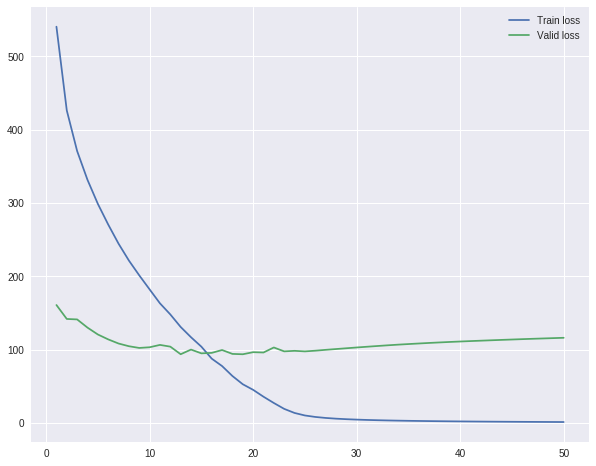

In [30]:
grid = np.arange(1, num_epochs + 1)
plt.plot(grid, train_loss_plot, label='Train loss')
plt.plot(grid, valid_loss_plot, label='Valid loss')

plt.legend()
plt.show()

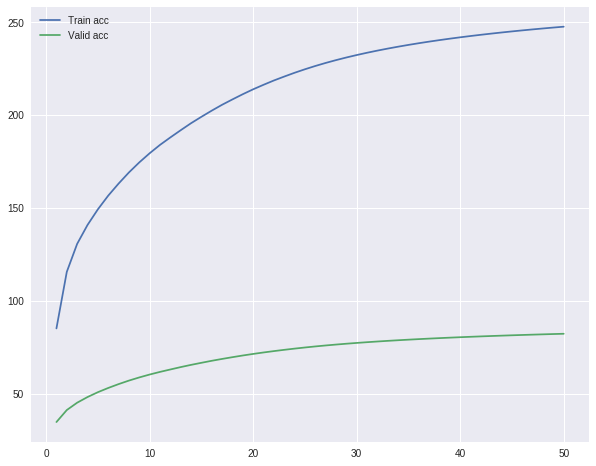

In [31]:
grid = np.arange(1, num_epochs + 1)
plt.plot(grid, train_acc_plot, label='Train acc')
plt.plot(grid, valid_acc_plot, label='Valid acc')

plt.legend()
plt.show()

ЧЕТВЕРТАЯ НЕЙРОСЕТЬ

In [0]:
conv1 = tf.layers.conv2d(
    inputs=input_X,
    filters=64,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)

pool1 = tf.layers.max_pooling2d(
    inputs=conv1, 
    pool_size=[2, 2], 
    strides=2)

conv2 = tf.layers.conv2d(
    inputs=pool1,
    filters=128,
    kernel_size=[4, 4],
    padding="same",
    activation=tf.nn.elu)

pool2 = tf.layers.max_pooling2d(
    inputs=conv2, 
    pool_size=[2, 2], 
    strides=2)

dropout = tf.layers.dropout(
    inputs=pool2, 
    rate=0.3)

conv3 = tf.layers.conv2d(
    inputs=dropout,
    filters=256,
    kernel_size=[5, 5],
    padding="same",
    activation=tf.nn.tanh)

pool3 = tf.layers.max_pooling2d(
    inputs=conv3, 
    pool_size=[2, 2], 
    strides=2)

conv4 = tf.layers.conv2d(
    inputs=pool3,
    filters=512,
    kernel_size=[4, 4],
    padding="same",
    activation=tf.nn.relu)

pool4 = tf.layers.max_pooling2d(
    inputs=conv4, 
    pool_size=[2, 2], 
    strides=2)

pool4_flat = tf.reshape(pool4, [-1, 2 * 2 * 512])

dense = tf.layers.dense(
    inputs=pool4_flat, 
    units=2048, 
    activation=tf.nn.relu)

dropout = tf.layers.dropout(
    inputs=dense, 
    rate=0.3)

logits = tf.layers.dense(inputs=dropout, units=10)

loss = tf.losses.sparse_softmax_cross_entropy(labels=input_y, logits=logits)

optimizer_step = (
    tf.train.GradientDescentOptimizer(0.004, use_locking=True).minimize(loss))

y_pred = tf.argmax(input=logits, axis=1)
acc = tf.metrics.accuracy(labels=input_y, predictions=tf.argmax(input=logits, axis=1))

In [33]:
num_epochs = 50 
batch_size = 128
train_loss_plot = []
train_acc_plot = []
valid_loss_plot = []
valid_acc_plot = []

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    tf.local_variables_initializer().run()
    
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_loss = 0
        train_acc = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches(X_train, y_train, batch_size):
            inputs, targets = batch
            train_loss_batch, train_acc_batch = train_fn(inputs, targets, sess)
            train_loss += train_loss_batch
            train_acc += train_acc_batch
            train_batches += 1
    
        # And a full pass over the validation data:
        valid_loss = 0
        valid_acc = 0
        valid_batches = 0
        for batch in iterate_minibatches(X_val, y_val, batch_size):
            inputs, targets = batch
            valid_loss_batch, valid_acc_batch = eval_fn(inputs, targets, sess)
            valid_loss += valid_loss_batch
            valid_acc += valid_acc_batch
            valid_batches += 1
    
        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
        print("  train loss:\t\t{:.6f}".format(train_loss / train_batches))
        print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
        print("  valid loss:\t\t{:.6f}".format(valid_loss / valid_batches))
        print("  valid accuracy:\t\t{:.2f} %".format(valid_acc / valid_batches * 100))
        
        train_loss_plot += [train_loss]
        train_acc_plot += [train_acc]
        valid_loss_plot += [valid_loss]
        valid_acc_plot += [valid_acc]
    
    test_acc = 0
    test_batches = 0
    for batch in iterate_minibatches(X_test, y_test, 128):
        inputs, targets = batch
        _, tmp_acc = eval_fn(inputs, targets, sess)
        test_acc += tmp_acc
        test_batches += 1
    print("Final results:")
    print("  test accuracy:\t\t{:.2f} %".format(test_acc / test_batches * 100))

Epoch 1 of 50 took 36.051s
  train loss:		1.855729
  train accuracy:		29.58 %
  valid loss:		1.696652
  valid accuracy:		35.84 %
Epoch 2 of 50 took 35.899s
  train loss:		1.491314
  train accuracy:		39.15 %
  valid loss:		1.490656
  valid accuracy:		42.02 %
Epoch 3 of 50 took 35.970s
  train loss:		1.290648
  train accuracy:		44.24 %
  valid loss:		1.394692
  valid accuracy:		46.21 %
Epoch 4 of 50 took 35.971s
  train loss:		1.152255
  train accuracy:		47.85 %
  valid loss:		1.318125
  valid accuracy:		49.39 %
Epoch 5 of 50 took 36.043s
  train loss:		1.048114
  train accuracy:		50.77 %
  valid loss:		1.235054
  valid accuracy:		52.08 %
Epoch 6 of 50 took 36.033s
  train loss:		0.956132
  train accuracy:		53.27 %
  valid loss:		1.191968
  valid accuracy:		54.38 %
Epoch 7 of 50 took 36.010s
  train loss:		0.868773
  train accuracy:		55.43 %
  valid loss:		1.101410
  valid accuracy:		56.47 %
Epoch 8 of 50 took 35.957s
  train loss:		0.793152
  train accuracy:		57.43 %
  valid loss:		1.11

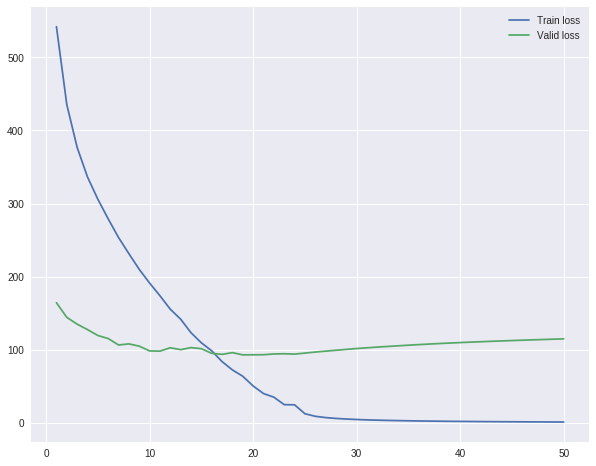

In [34]:
grid = np.arange(1, num_epochs + 1)
plt.plot(grid, train_loss_plot, label='Train loss')
plt.plot(grid, valid_loss_plot, label='Valid loss')

plt.legend()
plt.show()

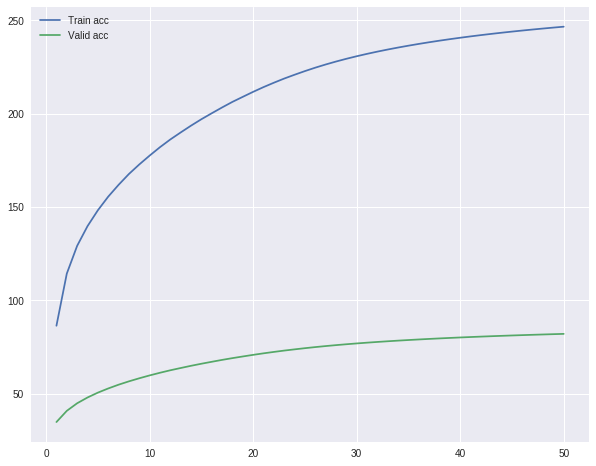

In [35]:
grid = np.arange(1, num_epochs + 1)
plt.plot(grid, train_acc_plot, label='Train acc')
plt.plot(grid, valid_acc_plot, label='Valid acc')

plt.legend()
plt.show()

ПЯТАЯ НЕЙРОСЕТЬ

In [0]:
conv1 = tf.layers.conv2d(
    inputs=input_X,
    filters=64,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)

pool1 = tf.layers.max_pooling2d(
    inputs=conv1, 
    pool_size=[2, 2], 
    strides=2)

conv2 = tf.layers.conv2d(
    inputs=pool1,
    filters=128,
    kernel_size=[4, 4],
    padding="same",
    activation=tf.nn.elu)

pool2 = tf.layers.max_pooling2d(
    inputs=conv2, 
    pool_size=[2, 2], 
    strides=2)

dropout = tf.layers.dropout(
    inputs=pool2, 
    rate=0.2)

conv3 = tf.layers.conv2d(
    inputs=dropout,
    filters=256,
    kernel_size=[5, 5],
    padding="same",
    activation=tf.nn.tanh)

pool3 = tf.layers.max_pooling2d(
    inputs=conv3, 
    pool_size=[2, 2], 
    strides=2)

conv4 = tf.layers.conv2d(
    inputs=pool3,
    filters=512,
    kernel_size=[4, 4],
    padding="same",
    activation=tf.nn.relu)

pool4 = tf.layers.max_pooling2d(
    inputs=conv4, 
    pool_size=[2, 2], 
    strides=2)

pool4_flat = tf.reshape(pool4, [-1, 2 * 2 * 512])

dense = tf.layers.dense(
    inputs=pool4_flat, 
    units=2048, 
    activation=tf.nn.relu)

dropout = tf.layers.dropout(
    inputs=dense, 
    rate=0.2)

logits = tf.layers.dense(inputs=dropout, units=10)

loss = tf.losses.sparse_softmax_cross_entropy(labels=input_y, logits=logits)

optimizer_step = (
    tf.train.GradientDescentOptimizer(0.0045, use_locking=True).minimize(loss))

y_pred = tf.argmax(input=logits, axis=1)
acc = tf.metrics.accuracy(labels=input_y, predictions=tf.argmax(input=logits, axis=1))

In [39]:
num_epochs = 50 
batch_size = 64
train_loss_plot = []
train_acc_plot = []
valid_loss_plot = []
valid_acc_plot = []

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    tf.local_variables_initializer().run()
    
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_loss = 0
        train_acc = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches(X_train, y_train, batch_size):
            inputs, targets = batch
            train_loss_batch, train_acc_batch = train_fn(inputs, targets, sess)
            train_loss += train_loss_batch
            train_acc += train_acc_batch
            train_batches += 1
    
        # And a full pass over the validation data:
        valid_loss = 0
        valid_acc = 0
        valid_batches = 0
        for batch in iterate_minibatches(X_val, y_val, batch_size):
            inputs, targets = batch
            valid_loss_batch, valid_acc_batch = eval_fn(inputs, targets, sess)
            valid_loss += valid_loss_batch
            valid_acc += valid_acc_batch
            valid_batches += 1
    
        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
        print("  train loss:\t\t{:.6f}".format(train_loss / train_batches))
        print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
        print("  valid loss:\t\t{:.6f}".format(valid_loss / valid_batches))
        print("  valid accuracy:\t\t{:.2f} %".format(valid_acc / valid_batches * 100))
        
        train_loss_plot += [train_loss / train_batches]
        train_acc_plot += [train_acc / train_batches * 100]
        valid_loss_plot += [valid_loss / valid_batches]
        valid_acc_plot += [valid_acc / valid_batches * 100]
    
    test_acc = 0
    test_batches = 0
    for batch in iterate_minibatches(X_test, y_test, 64):
        inputs, targets = batch
        _, tmp_acc = eval_fn(inputs, targets, sess)
        test_acc += tmp_acc
        test_batches += 1
    print("Final results:")
    print("  test accuracy:\t\t{:.2f} %".format(test_acc / test_batches * 100))

Epoch 1 of 50 took 42.287s
  train loss:		1.768694
  train accuracy:		30.82 %
  valid loss:		1.649162
  valid accuracy:		38.47 %
Epoch 2 of 50 took 42.060s
  train loss:		1.289905
  train accuracy:		42.73 %
  valid loss:		1.491607
  valid accuracy:		46.28 %
Epoch 3 of 50 took 42.067s
  train loss:		1.049962
  train accuracy:		49.04 %
  valid loss:		1.331599
  valid accuracy:		51.59 %
Epoch 4 of 50 took 42.098s
  train loss:		0.876681
  train accuracy:		53.78 %
  valid loss:		1.274282
  valid accuracy:		55.78 %
Epoch 5 of 50 took 42.051s
  train loss:		0.732234
  train accuracy:		57.54 %
  valid loss:		1.124974
  valid accuracy:		59.29 %
Epoch 6 of 50 took 42.138s
  train loss:		0.610384
  train accuracy:		60.88 %
  valid loss:		1.092792
  valid accuracy:		62.38 %
Epoch 7 of 50 took 42.038s
  train loss:		0.506042
  train accuracy:		63.77 %
  valid loss:		1.040192
  valid accuracy:		65.07 %
Epoch 8 of 50 took 42.095s
  train loss:		0.406373
  train accuracy:		66.31 %
  valid loss:		1.00

<h1 align="center">Report</h1>

В процессе выполнения я написал несколько нейросетей. По порядку расскажу о них.

### Первая нейросеть

Взял пример с семинара, взял пример с сайта TF, и собрал некий baseline.  
Получилось с одной стороны неплохо - быстро + не нулевой score. Из минусов - я не добавил рисование графиков, score все-таки маленький.

### Вторая нейросеть

Так как меня волновал больше всего score, то во второй нейросети я просто увеличил количество эпох.  
**БИНГО!**  
Получил >85 на тесте.

### Третья нейросеть

Меня напрягало две вещи - отсутствие графиков и увеличивающийся на валидации loss. Поговорив с титанами ML, я пришел к выводу, что у меня переобучение, поэтому увеличил Dropout и уменьшил Learning Rate. Loss, конечно, уменьшился, но вмести с ним и score.  
Появились графики - на них подтверждались опасения о переобучении.

### Четвертая нейросеть

Еще увеличил Dropout. Добавил нейронов.  
Какого-то колоссального эффекта не произошло.

### Пятая нейросеть

Большой score был у второй нейросети. Я решил вернуться в некотором смысле к ней. А именно - перестать напрягаться по поводу loss на валидации.  
Я уменьшил Dropout, увеличил Learning Rate и уменьшил batch size.  
Я забыл нарисовать графики (время кончается, не успею нарисовать еще раз) - но и так видно, что на обучающей все ок, а на валидации все плохо.  
**БИНГО!**  
Получил >88 на тесте.